In [48]:
#Charger, prétraiter et examiner les données
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

# Code optionnel pour éliminer les warnings

from warnings import filterwarnings
filterwarnings('ignore')

<p><b>Hypothèse de travail</b>: la dégradation de la tension électrique se produit progressivement dans le temps, par conséquent, on utilise un point de données toutes les 1 minute dans notre  analyse</p>

In [49]:
#Téléchargement du jeu de données et visualisations des 5 premières lignes
data=pd.read_excel(r"C:\Users\dell\Desktop\Projet_Analyse_Magal2021\DonneesPostes.xlsx", parse_dates=['Data_tstmp'], index_col='Data_tstmp')
data.head()

,PosteSource,Feeder,Ouvrage,Puissance,Rapport_TC,rapport_tp,U1,U2,U3,V1,V2,V3,I1,I2,I3,Puissance Active,S_Approximee,Q_Approximee
Data_tstmp,,,,,,,,,,,,,,,,,,
2021-08-01 00:00:00,TOUBA,DAROU TANZIL,DAROU MINAM 2,630,200,1,406.512325,406.858735,407.031940,234.7,234.9,235.0,453.4,403.0,364.6,275.553,286.772200,79.428200
2021-08-01 00:10:00,TOUBA,DAROU TANZIL,DAROU MINAM 2,630,200,1,411.535272,411.708477,411.708477,237.6,237.7,237.7,450.8,404.4,368.4,279.338,290.808933,80.870991
2021-08-01 00:20:00,TOUBA,DAROU TANZIL,DAROU MINAM 2,630,200,1,412.747707,412.747707,412.747707,238.3,238.3,238.3,434.4,390.6,358.2,271.631,281.956560,75.604904
2021-08-01 00:30:00,TOUBA,DAROU TANZIL,DAROU MINAM 2,630,200,1,415.692194,415.865399,415.865399,240.0,240.1,240.1,426.6,383.4,356.6,269.699,280.061773,75.478779
2021-08-01 00:40:00,TOUBA,DAROU TANZIL,DAROU MINAM 2,630,200,1,411.362067,411.535272,411.535272,237.5,237.6,237.6,426.4,388.0,352.2,266.521,277.145273,76.000387


In [50]:
colonne = data.columns
colonne

Index(['PosteSource', 'Feeder', 'Ouvrage', 'Puissance', 'Rapport_TC',
       'rapport_tp', 'U1', 'U2', 'U3', 'V1', 'V2', 'V3', 'I1', 'I2', 'I3',
       'Puissance Active', 'S_Approximee', 'Q_Approximee'],
      dtype='object')

In [51]:
#Sélection de variables:
df=data[[colonne[2] , colonne[9], colonne[10], colonne[11], colonne[12], colonne[13],
       colonne[14], colonne[15]]]
#Renommer la feature Puissance Active en P
df.rename(columns={df.columns[7]:'P', df.columns[0]: 'OUVRAGE'}, inplace=True)
df.head()

,OUVRAGE,V1,V2,V3,I1,I2,I3,P
Data_tstmp,,,,,,,,
2021-08-01 00:00:00,DAROU MINAM 2,234.7,234.9,235.0,453.4,403.0,364.6,275.553
2021-08-01 00:10:00,DAROU MINAM 2,237.6,237.7,237.7,450.8,404.4,368.4,279.338
2021-08-01 00:20:00,DAROU MINAM 2,238.3,238.3,238.3,434.4,390.6,358.2,271.631
2021-08-01 00:30:00,DAROU MINAM 2,240.0,240.1,240.1,426.6,383.4,356.6,269.699
2021-08-01 00:40:00,DAROU MINAM 2,237.5,237.6,237.6,426.4,388.0,352.2,266.521


In [52]:
#Nombre de ligne null
df.isnull().sum(axis=0)/len(df)*100

OUVRAGE     0.000000
V1         20.005126
V2         20.005126
V3         20.005126
I1          5.040104
I2          5.040104
I3          5.040104
P           5.040104
dtype: float64

In [53]:
#Traitement des valeurs manquantes: suppression des lignes où tous les features sont null
df.dropna(subset=['V1','V2','V3','I1','I2','I3','P'], axis=0, how='all', inplace=True)
len(df)

62985

In [54]:
#Remplacement des valeurs null restantes par la moyennne: technique d'imputation par la moyenne
df['V1'].fillna(value=df['V1'].mean(), axis=0, inplace=True)
df['V2'].fillna(value=df['V2'].mean(), axis=0, inplace=True)
df['V3'].fillna(value=df['V3'].mean(), axis=0, inplace=True)
df.isnull().sum()

OUVRAGE    0
V1         0
V2         0
V3         0
I1         0
I2         0
I3         0
P          0
dtype: int64

In [55]:
#Nombre d'observations(ligne de données) par postes
df.OUVRAGE.value_counts()

MINAM 7                   17013
DAROU MARNANE              9471
PALENE ROUTE DE MBACKE     9137
DAROU MINAM 2              8218
OCASE CPT2                 7851
DAROU MINAM 1              5885
PALENE                     5410
Name: OUVRAGE, dtype: int64

In [56]:
#Selection de variables importantes: Features Engeneering
Var=['V1','V2','V3']
poste='DAROU MINAM 2'
df_params=df[df.OUVRAGE==poste][Var]

In [57]:
df_params=round(df_params,3)        #arrondi à trois chiffres après la virgule pour éviter le bruit lors de l'apprentissage
df_params

,V1,V2,V3
Data_tstmp,,,
2021-08-01 00:00:00,234.7,234.9,235.0
2021-08-01 00:10:00,237.6,237.7,237.7
2021-08-01 00:20:00,238.3,238.3,238.3
2021-08-01 00:30:00,240.0,240.1,240.1
2021-08-01 00:40:00,237.5,237.6,237.6
...,...,...,...
2021-09-28 22:50:00,240.6,239.6,240.7
2021-09-28 23:00:00,240.8,239.5,240.8
2021-09-28 23:10:00,240.7,239.7,240.8


In [58]:
df_params.sort_values(by=['Data_tstmp'], inplace=True)      #trie dans l'ordre croissant 

In [59]:
#60% des données pour l'entrainement
mask_train = ((df_params.index >= '2021-08-07') & (df_params.index <= '2021-08-19'))
mask_test = (df_params.index > '2021-08-19')

In [60]:
train, test = df_params.loc[mask_train ], df_params.loc[mask_test ]
print(train.shape)
print(test.shape)

(1694, 3)
(5820, 3)


<AxesSubplot:xlabel='V1', ylabel='Density'>

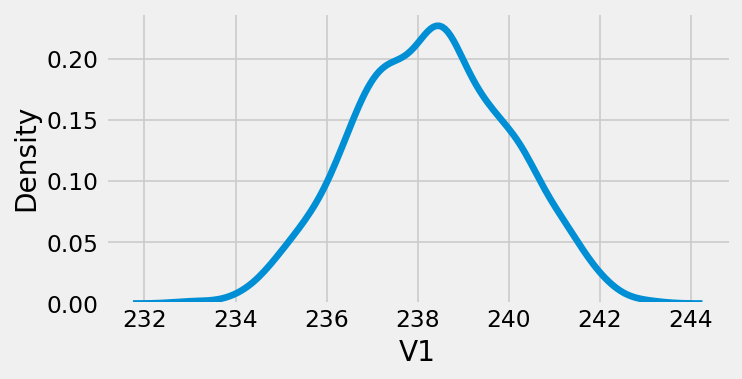

In [61]:
sns.distplot(train.V1, kde=True, hist=False)  #kde: kernel density estimate

In [62]:
#Test de normalité de X_train
#H0: X_train ne suit pas une loi normale: on rejète H0 car p-value <5%--->X_train suit une loi normale--->on pourra appliquer la règle des 3 sigma
from scipy import stats
#test de shapiro wilk et de jarque_bera
print(stats.jarque_bera(train.V1))
print(stats.shapiro(train.V1))

Jarque_beraResult(statistic=9.76035543674547, pvalue=0.007595664018571147)
ShapiroResult(statistic=0.9970539212226868, pvalue=0.002711821347475052)


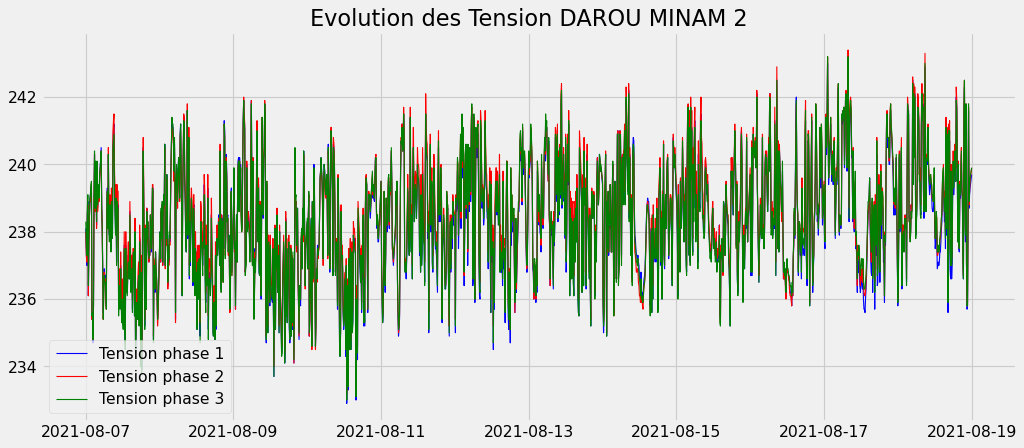

In [63]:
#Traçons les tendances de nos données d'entrainement
fig, ax=plt.subplots(figsize=(14,6), dpi=80)
ax.plot(train.V1, label='Tension phase 1', color='blue', animated=True, linewidth=1)
ax.plot(train.V2, label='Tension phase 2', color='red', animated=True, linewidth=1)
ax.plot(train.V3, label='Tension phase 3', color='green', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Evolution des Tension '+poste)
plt.show()

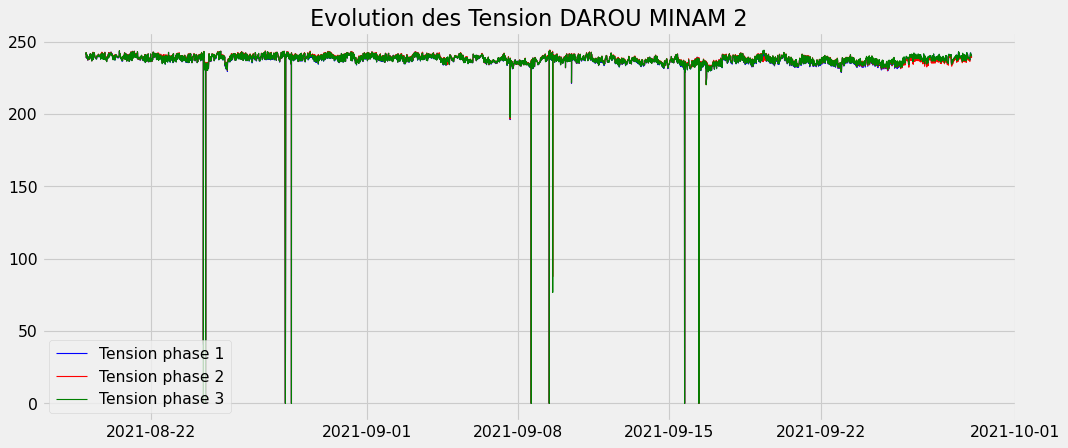

In [64]:
#Traçons les tendances de nos données de test
fig, ax=plt.subplots(figsize=(14,6), dpi=80)
ax.plot(test.V1, label='Tension phase 1', color='blue', animated=True, linewidth=1)
ax.plot(test.V2, label='Tension phase 2', color='red', animated=True, linewidth=1)
ax.plot(test.V3, label='Tension phase 3', color='green', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Evolution des Tension '+poste)
plt.show()

In [65]:
'''transformons le signal du domaine temporel au domaine fréquentiel 
à l'aide d'une transformée de Fourier.'''


"transformons le signal du domaine temporel au domaine fréquentiel \nà l'aide d'une transformée de Fourier."

In [66]:
train_fft=np.fft.fft(train)
test_fft=np.fft.fft(test)

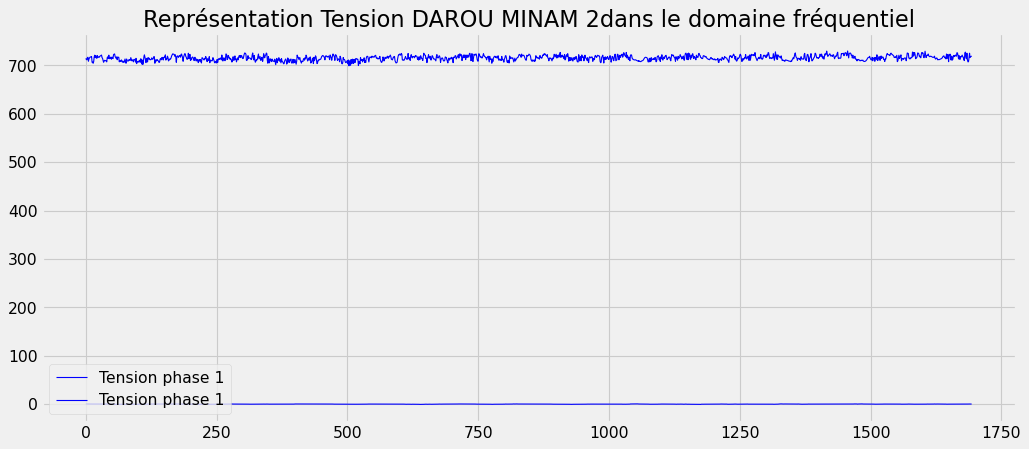

In [67]:
fig, ax=plt.subplots(figsize=(14,6), dpi=80)
ax.plot(train_fft[:,0].real, label='Tension phase 1', color='blue', animated=True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Tension phase 1', color='blue', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Représentation Tension '+poste+'dans le domaine fréquentiel')
plt.show()

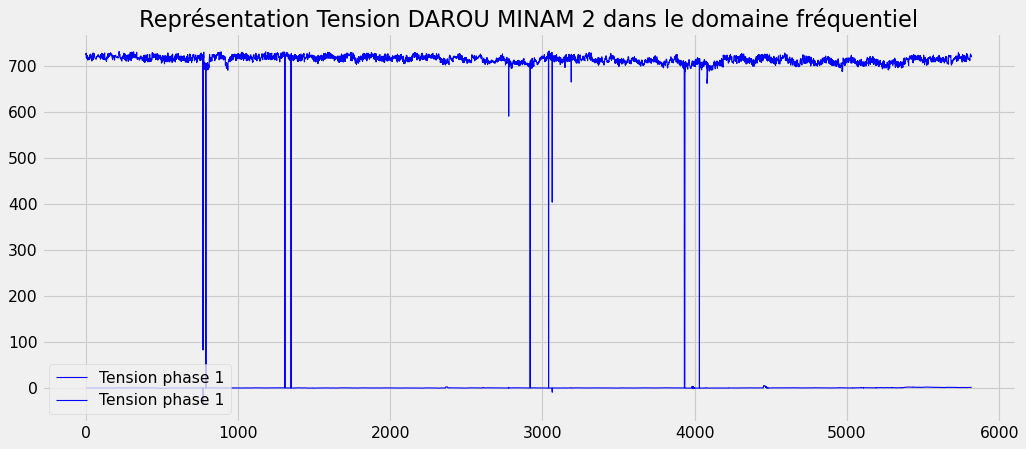

In [68]:
fig, ax=plt.subplots(figsize=(14,6), dpi=80)
ax.plot(test_fft[:,0].real, label='Tension phase 1', color='blue', animated=True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Tension phase 1', color='blue', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Représentation Tension '+poste+' dans le domaine fréquentiel')
plt.show()

In [69]:
#Mise à l'échelle de nos données
scaler=MinMaxScaler()                   #RobustScaler(quantile_range=(25, 75))
scaler=scaler.fit(train)
X_train=scaler.transform(train)
X_test=scaler.transform(test)


In [70]:
#Convertir les données au format accepté par les auto-encodeurs LSTM
X_train=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test=X_test.reshape(X_test.shape[0],1,X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(1694, 1, 3)
(5820, 1, 3)


In [71]:
X_test

array([[[0.84313725, 0.83333333, 0.85294118]],

       [[0.82352941, 0.80392157, 0.82352941]],

       [[0.91176471, 0.90196078, 0.92156863]],

       ...,

       [[0.76470588, 0.6372549 , 0.76470588]],

       [[0.69607843, 0.56862745, 0.70588235]],

       [[0.66666667, 0.53921569, 0.66666667]]])

In [72]:
#Définition du model auto encodeur automatique LSTM: Programmation Fonctional API
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(64, activation='relu', return_sequences=True)(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(32, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(64, activation='relu',return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model=Model(inputs=inputs, outputs=output)
    return model

In [73]:
#Compilation du model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 64)             17408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 32)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 3)              195 

In [74]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)  #patience= nombre d'epoch avant d'arreter

In [75]:
#Entrainement du model
history = model.fit(X_train, X_train,
                   epochs=50,
                   batch_size=1,
                   validation_split=0.2,
                   shuffle=False, callbacks=[early_stop]).history

Epoch 1/50
1355/1355 [==============================] - 11s 4ms/step - loss: 0.1248 - val_loss: 0.1167
Epoch 2/50
1355/1355 [==============================] - 5s 3ms/step - loss: 0.0384 - val_loss: 0.0467
Epoch 3/50
1355/1355 [==============================] - 6s 4ms/step - loss: 0.0206 - val_loss: 0.0231
Epoch 4/50
1355/1355 [==============================] - 5s 4ms/step - loss: 0.0100 - val_loss: 0.0259
Epoch 5/50
1355/1355 [==============================] - 5s 4ms/step - loss: 0.0102 - val_loss: 0.0219
Epoch 6/50
1355/1355 [==============================] - 6s 4ms/step - loss: 0.0096 - val_loss: 0.0240
Epoch 7/50
1355/1355 [==============================] - 6s 4ms/step - loss: 0.0089 - val_loss: 0.0233


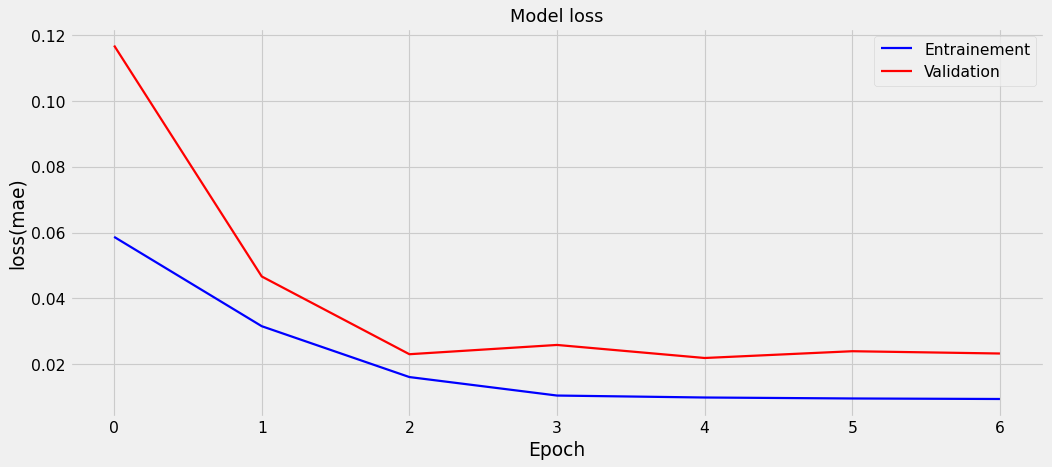

In [76]:
#Affichage de l'évolution de la fonction loss en fonction des epochs
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Entrainement', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('loss(mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

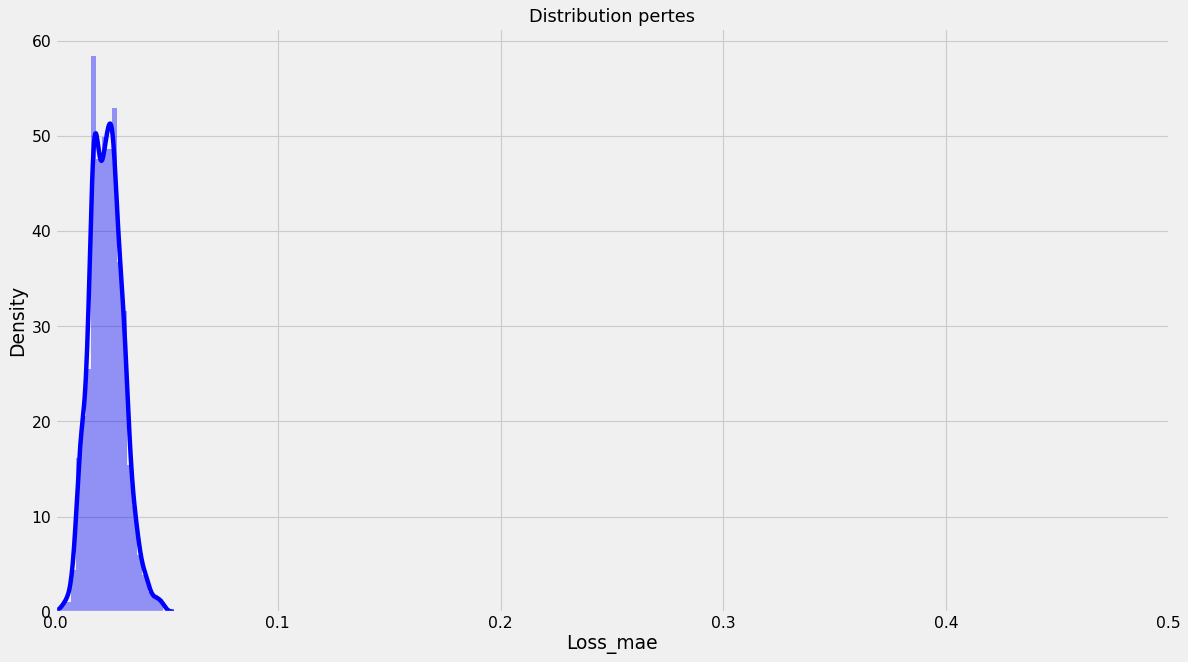

In [77]:
#histogramme des de la fonction loss
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Distribution pertes', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color ='blue');
plt.xlim([0.0, .5])

In [78]:
'''calculer le seuil: règle des 3 sigma : si une variable suit une loi normale 99,73 % de ses valeurs sont centrées 
autour de la moyenne et sont situées dans l'intervalle [moy - 3*std, moy + 3*std] '''
std_x_train=np.std(scored.Loss_mae)*3
mean_x_train=np.mean(scored.Loss_mae)
seuil =std_x_train
print(seuil)

0.021778353526836505


In [79]:
#calcul des pertes dans le jeu de test et détection des anomalies
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index = test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)
scored['seuil']=seuil
scored['Anomalie']=scored['Loss_mae']>scored['seuil']
scored.head()

,Loss_mae,seuil,Anomalie
Data_tstmp,,,
2021-08-19 00:10:00,0.025571,0.021778,True
2021-08-19 00:20:00,0.026080,0.021778,True
2021-08-19 00:30:00,0.023763,0.021778,True
2021-08-19 00:40:00,0.016707,0.021778,False
2021-08-19 00:50:00,0.016962,0.021778,False


In [80]:
len(scored)

5820

In [81]:
#calcul des pertes dans le jeu d'entrainement
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns = train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index = train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis=1)
scored_train['seuil']=seuil
scored_train['Anomalie']=scored_train['Loss_mae']>scored_train['seuil']
scored_train.head()

,Loss_mae,seuil,Anomalie
Data_tstmp,,,
2021-08-07 00:00:00,0.016059,0.021778,False
2021-08-07 00:10:00,0.010877,0.021778,False
2021-08-07 00:20:00,0.009209,0.021778,False
2021-08-07 00:30:00,0.017229,0.021778,False
2021-08-07 00:40:00,0.016330,0.021778,False


(0.0, 0.5)

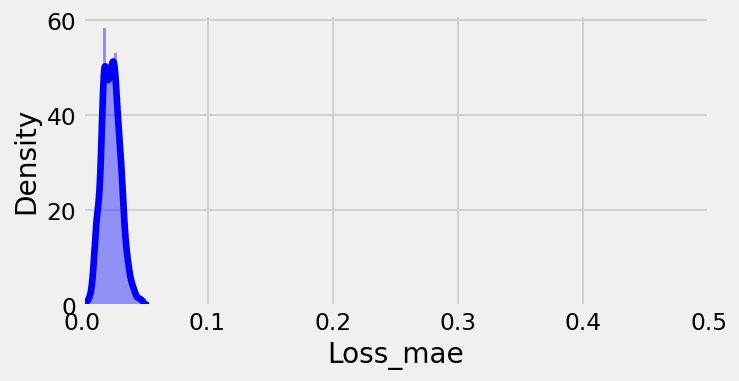

In [82]:
sns.distplot(scored_train['Loss_mae'], bins=20, kde=True, color ='blue');
plt.xlim([0.0, .5])

In [83]:
#Visualisation du résultat
#scored.plot(logy=True, figsize=(16,9), color=['blue', 'red'])

In [84]:
anomalies= scored[scored.Anomalie==True]
anomalies

,Loss_mae,seuil,Anomalie
Data_tstmp,,,
2021-08-19 00:10:00,0.025571,0.021778,True
2021-08-19 00:20:00,0.026080,0.021778,True
2021-08-19 00:30:00,0.023763,0.021778,True
2021-08-19 01:30:00,0.023387,0.021778,True
2021-08-19 01:40:00,0.022132,0.021778,True
...,...,...,...
2021-09-28 22:50:00,0.035236,0.021778,True
2021-09-28 23:00:00,0.045862,0.021778,True
2021-09-28 23:10:00,0.035182,0.021778,True


In [85]:
anomalies_nbr=anomalies.resample('D').mean()
anomalies_nbr.dropna()

,Loss_mae,seuil,Anomalie
Data_tstmp,,,
2021-08-19,0.029590,0.021778,True
2021-08-20,0.032593,0.021778,True
2021-08-21,0.030853,0.021778,True
2021-08-22,0.034973,0.021778,True
2021-08-23,0.027215,0.021778,True
2021-08-24,0.547423,0.021778,True
2021-08-25,0.037301,0.021778,True
2021-08-26,0.030675,0.021778,True
2021-08-27,0.027642,0.021778,True


In [86]:
#import joblib
#model.save(r'C:\Users\dell\Desktop\Projet_Analyse_Magal2021\defaut_tension_model.h5')
#joblib.dump(scaler, r"C:\Users\dell\Desktop\Projet_Analyse_Magal2021\tension_scaler.pkl")

['C:\\Users\\dell\\Desktop\\Projet_Analyse_Magal2021\\tension_scaler.pkl']

In [87]:
def collect_donnes(lien):
    #bibliothèques nécessairesCharger, prétraiter et examiner les données
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import joblib, smtplib
    %matplotlib inline
    #Téléchargement du jeu de données et visualisations des 5 premières lignes
    data=pd.read_excel(lien, parse_dates=['Data_tstmp'], index_col='Data_tstmp')
    data.head()
    return data

def pretraitement(data):
    #Sélection de variables 
    import joblib, smtplib
    data_scaler = joblib.load(r"C:\Users\dell\Desktop\Projet_Analyse_Magal2021\tension_scaler.pkl")
    df=data[['Ouvrage', 'V1', 'V2', 'V3', 'I1', 'I2', 'I3',
       'Puissance Active']]
    OUVRAGE=df.Ouvrage[0]
    #Renommer la feature Puissance Active en P
    df.rename(columns={'Puissance Active':'P'}, inplace=True)
    #Traitement des valeurs manquantes: suppression des lignes où tous les features sont null
    df.dropna(subset=['V1','V2','V3','I1','I2','I3','P'], axis=0, how='all', inplace=True)
    #Remplacement des valeurs null restantes par la moyennne: technique d'imputation par la moyenne
    df['V1'].fillna(value=df['V1'].mean(), axis=0, inplace=True)
    df['V2'].fillna(value=df['V2'].mean(), axis=0, inplace=True)
    df['V3'].fillna(value=df['V3'].mean(), axis=0, inplace=True)
    #Selection de variables importantes: Features Engeneering
    Var=['V1','V2','V3']
    data_traite=df[Var]
    print("Historique des anomalies au poste :{}".format(OUVRAGE))
    return data_traite
    

def prediction(lien):
    from tensorflow.keras.models import load_model
    from sklearn.preprocessing import StandardScaler, RobustScaler
    import joblib
    import numpy as np
    import pandas as pd, smtplib 
    import matplotlib.pyplot as plt
    from smtplib import SMTP
    
    data_model = load_model(r"C:\Users\dell\Desktop\Projet_Analyse_Magal2021\defaut_tension_model.h5")
    data_scaler = joblib.load(r"C:\Users\dell\Desktop\Projet_Analyse_Magal2021\tension_scaler.pkl")
    data = collect_donnes(lien)
    data_traite = pretraitement(data)
    scaled_data = scaler.transform(data_traite)
    
    scaled_data_reshap=scaled_data.reshape(scaled_data.shape[0],1,scaled_data.shape[1])
 
    
    
    X_pred = model.predict(scaled_data_reshap)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=train.columns)
    X_pred.index = data_traite.index

    scored = pd.DataFrame(index=data_traite.index)
    Xtrain = scaled_data.reshape(scaled_data_reshap.shape[0], scaled_data_reshap.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
    #calculer le seuil de décision
    std_x_train=np.std(scored.Loss_mae)*3
    mean_x_train=np.mean(scored.Loss_mae)
    seuil =std_x_train
    
    #calcul des pertes dans le jeu de donnees

    scored['seuil']=seuil
    scored['Anomalie']=scored['Loss_mae']>scored['seuil']
    #Visualisation du résultat
    scored.plot(logy=True, figsize=(16,9), color=['blue', 'red'])
    anomalies= scored[scored.Anomalie==True]
    anomalies_nbr=anomalies.resample('D').mean()
    anomalies_detectees = anomalies_nbr.dropna()
    anomalies_detectees = anomalies_detectees.drop(['Loss_mae', 'seuil'], axis=1)
    
    #Notification par e-mail
    # SMTP_SSL Example
    server_ssl = smtplib.SMTP_SSL("smtp.gmail.com", 465)
    server_ssl.ehlo() # optional, called by login()
    server_ssl.login('senemao86@gmail.com', '222205058686')  
    # ssl server doesn't support or need tls, so don't call server_ssl.starttls() 
    msg= str(anomalies_detectees)        # ['Anomalie'])
    server_ssl.sendmail('senemao86@gmail.com', ['senemao86@gmail.com'], msg)
    #server_ssl.quit()
    server_ssl.close()
    

    return anomalies_detectees


Historique des anomalies au poste :PALENE


,Anomalie
Data_tstmp,
2021-09-14,1.0
2021-09-18,1.0
2021-09-23,1.0
2021-09-26,1.0


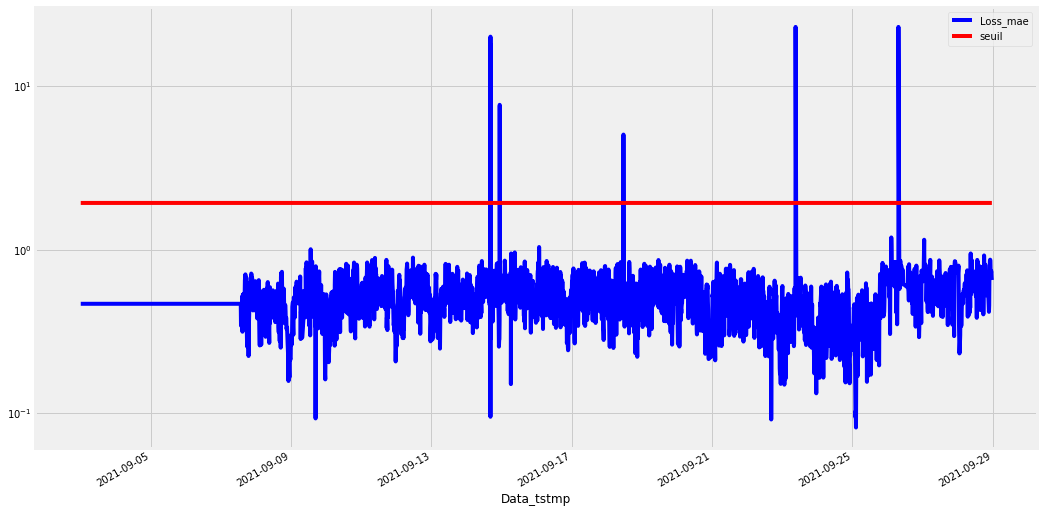

In [88]:
prediction(r'C:\Users\dell\Desktop\Projet_Analyse_Magal2021\test2.xlsx')